In [0]:
!/opt/bin/nvidia-smi
!nvcc --version

/bin/sh: 1: /opt/bin/nvidia-smi: not found
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [0]:
  !curl -s https://course.fast.ai/setup/colab | bash

mkdir: cannot create directory ‘/root’: Permission denied
mkdir: cannot create directory ‘/root’: Permission denied
ln: failed to create symbolic link '/content': Permission denied
ln: failed to create symbolic link '/content': Permission denied
Updating fastai...
Done.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
import os

In [0]:
!wget 'https://storage.googleapis.com/sherlock_datasets/MICC-F2000.zip'

--2020-04-09 16:42:15--  https://storage.googleapis.com/sherlock_datasets/MICC-F2000.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.128, 2a00:1450:4013:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4013307502 (3.7G) [application/zip]
Saving to: ‘MICC-F2000.zip.1’

MICC-F2000.zip.1      9%[>                   ] 368.45M   192MB/s               ^C


In [0]:
!unzip -o -q "MICC-F2000.zip"

In [0]:
path = Path("/home/tiago4k_gmail_com/MICC-F2000"); path

PosixPath('/home/tiago4k_gmail_com/MICC-F2000')

In [0]:
data = ImageDataBunch.from_folder(path, train='train', test='test', valid_pct=0.2, size=356, bs=15)

In [0]:
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (1484 items)
x: ImageList
Image (3, 356, 356),Image (3, 356, 356),Image (3, 356, 356),Image (3, 356, 356),Image (3, 356, 356)
y: CategoryList
Tampered,Tampered,Tampered,Tampered,Tampered
Path: /home/tiago4k_gmail_com/MICC-F2000;

Valid: LabelList (371 items)
x: ImageList
Image (3, 356, 356),Image (3, 356, 356),Image (3, 356, 356),Image (3, 356, 356),Image (3, 356, 356)
y: CategoryList
Authentic,Tampered,Tampered,Tampered,Authentic
Path: /home/tiago4k_gmail_com/MICC-F2000;

Test: LabelList (660 items)
x: ImageList
Image (3, 356, 356),Image (3, 356, 356),Image (3, 356, 356),Image (3, 356, 356),Image (3, 356, 356)
y: EmptyLabelList
,,,,
Path: /home/tiago4k_gmail_com/MICC-F2000

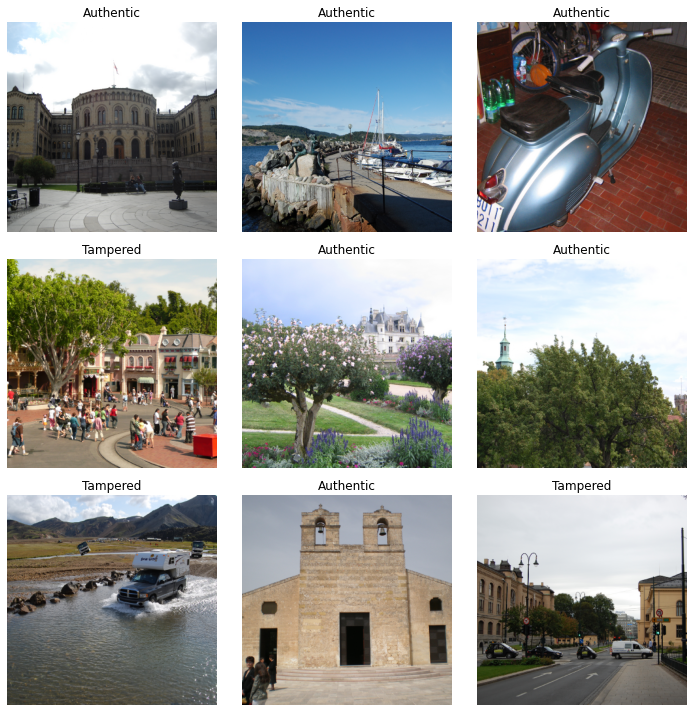

In [0]:
data.show_batch(rows=3, figsize=(10,10))

In [0]:
print(data.classes)
len(data.classes),data.c

['Authentic', 'Tampered']


(2, 2)

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=[accuracy, error_rate])

In [0]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [0]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.470360,0.413468,0.905660,0.094340,01:49
1,0.420935,0.228010,0.935310,0.064690,01:49
2,0.311903,0.179376,0.959569,0.040431,01:48
3,0.306266,0.240944,0.959569,0.040431,01:49
4,0.298103,0.224694,0.938005,0.061995,01:48
5,0.266280,0.157279,0.948787,0.051213,01:48
6,0.195935,0.150096,0.975741,0.024259,01:49
7,0.176477,0.161038,0.964960,0.035040,01:48
8,0.130352,0.170755,0.964960,0.035040,01:48
9,0.133065,0.160246,0.970350,0.029650,01:50


In [0]:
learn.save('attempt-1-resnet50')

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 6.31E-08


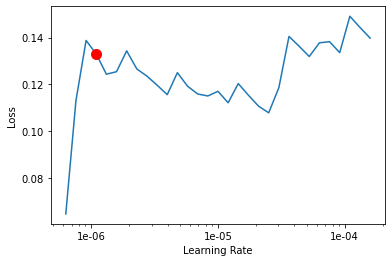

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
learn.fit_one_cycle(15, max_lr=slice(1e-5, 1e-6))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.138909,0.151269,0.973046,0.026954,01:49
1,0.118298,0.178190,0.962264,0.037736,01:49
2,0.134451,0.182473,0.962264,0.037736,01:49
3,0.126621,0.163274,0.964960,0.035040,01:49
4,0.138502,0.165452,0.970350,0.029650,01:50
5,0.101063,0.149862,0.973046,0.026954,01:50
6,0.115966,0.174889,0.964960,0.035040,01:50
7,0.118274,0.145625,0.975741,0.024259,01:49
8,0.119545,0.173176,0.967655,0.032345,01:49
9,0.105650,0.156556,0.978437,0.021563,01:49


In [0]:
learn.save('attempt-2-50resnet')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [0]:
interp.most_confused(min_val=2)

[('Authentic', 'Tampered', 11)]

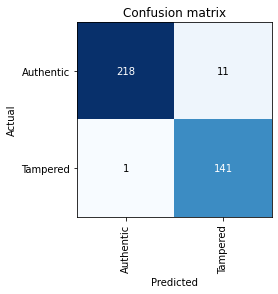

In [0]:
interp.plot_confusion_matrix()

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

Predictions

In [0]:
learn.export()

In [0]:
learn = load_learner(path)

In [0]:
path = '/home/tiago4k_gmail_com/MICC-F2000/test/'
folders = os.listdir(path)

count_fake = 0
count_real = 0

conf_list = []

for folder in folders:
    if os.path.isdir(path + folder):
        new_path = os.path.join(path + folder + '/')
        print(new_path)
        for f in os.listdir(new_path):
            img = open_image(new_path + f)
            pred_class,pred_idx,confidence = learn.predict(img)
            if str(pred_class) == 'Tampered':
                if 'Tampered' == folder:
                    count_fake += 1
                conf = float(confidence[1])
            elif str(pred_class) == 'Authentic':
                if 'Authentic' == folder:
                    count_real += 1
                conf = float(confidence[0])
            conf = conf * 100
            
            conf_list.append(conf)

/home/tiago4k_gmail_com/MICC-F2000/test/Tampered/
/home/tiago4k_gmail_com/MICC-F2000/test/Authentic/


In [0]:
total_fake = len(os.listdir(str(path) + '/Tampered/'))
total_real = len(os.listdir(str(path) + '/Authentic/'))

In [0]:
accuracy_fake = (count_fake/total_fake) * 100
accuracy_real = (count_real/total_real) * 100

print('Images Classified As Authentic')
print('{}/{}. Accuracy = {:.2f}%'.format(count_real, total_real, accuracy_real))

print('Images Classified As Tampered')
print('{}/{}. Accuracy = {:.2f}%'.format(count_fake, total_fake, accuracy_fake))

Images Classified As Authentic
413/429. Accuracy = 96.27%
Images Classified As Tampered
230/231. Accuracy = 99.57%


In [0]:
average_conf = sum(conf_list) / len(conf_list)

print('Average confidence of the model = {:.3f}%'.format(average_conf))

Average confidence of the model = 98.812%


In [0]:
img = open_image('/home/tiago4k_gmail_com/pogba_fake.jpg')
pred_class,pred_idx,confidence = learn.predict(img)

In [0]:
pred_class

Category Authentic